# OOD detection applied to Hallucination Detection

In [1]:
#/home/lila.roig/.env/ood_env/bin/python 

## Part II. Analyze results

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# import libraries
# -----------------------------------
import torch
import sys
import os 
import numpy as np
import pandas as pd
# Add the path to the src directory
sys.path.append(os.path.abspath(".."))

In [4]:
# Visualize setup 
# -----------------------------------
print(f"Python version: {sys.version}")
print(f"Cuda version: {torch.version.cuda}")
num_gpus = torch.cuda.device_count()
print(f"Number of available de GPU : {num_gpus}")
for i in range(num_gpus):
    print(f"GPU {i + 1} : {torch.cuda.get_device_name(i)}")

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Cuda version: 12.6
Number of available de GPU : 2
GPU 1 : NVIDIA GeForce RTX 4090
GPU 2 : NVIDIA GeForce RTX 4090


In [12]:
# Define global variables
# -----------------------------------
SEED = 777
BATCH_SIZE = 16
START_OFFSET = 0  # always 0 for now
END_OFFSET = 0    # always 0 for now

# Extract descriptors from: prompt, generated answer or both concatenated 
ACTIVATION_SOURCE = "prompt"  # 'prompt', 'generation', 'PromptGeneration'

# Define repository names
OUTPUT_DIR = f"../results/raw/small_dataset_allConfig_seed{SEED}/"
PLOT_DIR   = f"../results/figures/small_dataset_allConfig_seed{SEED}/"

# Define file name
STR_AGG = 'All'
STR_LAYERS = '1:32:2'
OUTPUT_TITLE = f"_layer{STR_LAYERS}_agg{STR_AGG}_{ACTIVATION_SOURCE}_so{START_OFFSET}_eo{END_OFFSET}_seed{SEED}"

In [7]:
# Seed everything
# -----------------------------------
from src.utils.general import seed_all
seed_all(SEED)

In [8]:
# Clear memory to avoid "CUDA out of memory"
# -----------------------------------
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

### 1. Load all extracted descriptors (obtained from Part I.)

In [13]:
# Load ID descriptors 
# -----------------------------------
from src.data_reader.pickle_io import load_pickle_batches
from src.utils.general import add_unanswerable_flag, filter_entries

# Load extracted descriptors 
id_fit_data = load_pickle_batches(f"{OUTPUT_DIR}id_fit_results{OUTPUT_TITLE}.pkl")

# Add unanswerable flag: check if the generated answer contains 'unanswerable' keyword
# Expect many 'unanswerable' flags in `od_test_data` and few in `id_test_data`, if model works well
id_fit_data = add_unanswerable_flag(id_fit_data)

# Filter descriptors: keep only answerable answers for ID
if False:  #### TODO: ADAPT TO NEW CODE VERSION ####
    id_fit_data = filter_entries(id_fit_data, column='is_unanswerable', value=0) 

Loaded 8008 samples from: ../results/raw/small_dataset_allConfig_seed777/id_fit_results_layer1:32:2_aggAll_prompt_so0_eo0_seed777.pkl


In [14]:
# Load test descriptors 
# -----------------------------------
from src.data_reader.pickle_io import load_pickle_batches
from src.utils.general import add_unanswerable_flag, filter_entries

# Load extracted possible and impossible descriptors 
od_test_data = load_pickle_batches(f"{OUTPUT_DIR}od_test_results{OUTPUT_TITLE}.pkl")
id_test_data = load_pickle_batches(f"{OUTPUT_DIR}id_test_results{OUTPUT_TITLE}.pkl")

# Add unanswerable flag: check if the generated answer contains 'unanswerable' keyword
# Expect many 'unanswerable' flags in `od_test_data` and few in `id_test_data`, if model works well
od_test_data = add_unanswerable_flag(od_test_data)
id_test_data = add_unanswerable_flag(id_test_data)

# Filter descriptors: keep only unanswerable answers for OOD, and only answerable answers for ID
if False: #### TODO: ADAPT TO NEW CODE VERSION ####
    od_test_data = filter_entries(od_test_data, column='is_unanswerable', value=1)
    id_test_data = filter_entries(id_test_data, column='is_unanswerable', value=0)

Loaded 1000 samples from: ../results/raw/small_dataset_allConfig_seed777/od_test_results_layer1:32:2_aggAll_prompt_so0_eo0_seed777.pkl
Loaded 1000 samples from: ../results/raw/small_dataset_allConfig_seed777/id_test_results_layer1:32:2_aggAll_prompt_so0_eo0_seed777.pkl


In [15]:
# Result DataFrame: Initialization with sample indexes and 'unanswerable' flag
# -----------------------------------
n_id  = len(id_test_data['id'])
n_ood = len(od_test_data['id'])
df_result = pd.DataFrame({
    'set': ['ID'] * n_id + ['OOD'] * n_ood,
    'index': list(range(n_id)) + list(range(n_ood)),
})
df_result['is_unanswerable'] = np.concatenate([
    id_test_data['is_unanswerable'],
    od_test_data['is_unanswerable']
])

### 2. Evaluate one configuration

#### 2.1. Extract one config from result dict

In [16]:
# Visualize all configurations available from loaded descriptors `id_fit_data`
# -----------------------------------
from src.analysis.analyze_ood_results import discover_config_space

space = discover_config_space(id_fit_data)
print(space)

{'layers': [-1, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29], 'hidden_aggs_by_layer': {-1: ['avg_emb', 'feat_var_emb', 'first_gen_emb', 'hidden_score', 'last_emb', 'max_emb'], 1: ['avg_emb', 'feat_var_emb', 'first_gen_emb', 'hidden_score', 'last_emb', 'max_emb'], 3: ['avg_emb', 'feat_var_emb', 'first_gen_emb', 'hidden_score', 'last_emb', 'max_emb'], 5: ['avg_emb', 'feat_var_emb', 'first_gen_emb', 'hidden_score', 'last_emb', 'max_emb'], 7: ['avg_emb', 'feat_var_emb', 'first_gen_emb', 'hidden_score', 'last_emb', 'max_emb'], 9: ['avg_emb', 'feat_var_emb', 'first_gen_emb', 'hidden_score', 'last_emb', 'max_emb'], 11: ['avg_emb', 'feat_var_emb', 'first_gen_emb', 'hidden_score', 'last_emb', 'max_emb'], 13: ['avg_emb', 'feat_var_emb', 'first_gen_emb', 'hidden_score', 'last_emb', 'max_emb'], 15: ['avg_emb', 'feat_var_emb', 'first_gen_emb', 'hidden_score', 'last_emb', 'max_emb'], 17: ['avg_emb', 'feat_var_emb', 'first_gen_emb', 'hidden_score', 'last_emb', 'max_emb'], 19: ['avg_emb', 'f

In [17]:
# Choose 1 configuration (layer, aggregation group, aggregation mode)
# -----------------------------------
TARGET_LAYER = -1
AGG_GROUP = 'hidden'              # logit, attention, hidden

AGG_MODE = 'avg_emb' # perplexity_score, logit_entropy_score, window_logit_entropy_score, 
                                 # attn_score, avg_emb, last_emb, max_emb, first_gen_emb, 
                                 # feat_var_emb, hidden_score

In [18]:
# Select one configuration (layer, group, aggregation) from all the available descriptors
# -----------------------------------
from src.analysis.analyze_ood_results import retrieve_one_config_from_dict

id_fit_descriptors  = retrieve_one_config_from_dict(id_fit_data,  layer=TARGET_LAYER, group=AGG_GROUP, aggregation=AGG_MODE)
id_test_descriptors = retrieve_one_config_from_dict(id_test_data, layer=TARGET_LAYER, group=AGG_GROUP, aggregation=AGG_MODE)
od_test_descriptors = retrieve_one_config_from_dict(od_test_data, layer=TARGET_LAYER, group=AGG_GROUP, aggregation=AGG_MODE)

#### 2.2. Compute OOD scores for the chosen config

In [19]:
# Define OOD methods configs
# -----------------------------------
config_dknn = {'k': 5, 'batch_size': BATCH_SIZE} # DKNN config
config_cosine = {'center_type':'all', 'seed': SEED, 'k': 5, 'batch_size': BATCH_SIZE} # Cosine Similarity config
config_maha = {'center_type':'mean', 'seed': SEED, 'k': 5} # Mahalanobis config
config_ocsvm = {'kernel':'rbf', 'nu': 0.1, 'gamma': 'scale'} # OCSVM config
config_isoforest = {'n_estimators':1000, 'contamination': 'auto', 'seed': SEED} # Isolation forest config

In [21]:
# Compute OOD scores:
# If the descriptors are embeddings (2D tensors):
#   - Compute OOD scores using OOD detection methods
#   - Choose `method` in {'dknn', 'cosine', 'mahalanobis', 'ocsvm', 'isoforest'} with matching config
# If the descriptros are already 1D scores:
#   - Use them directly as OOD scores; do not apply OOD methods 
#   - Choose `method='raw_scores'` ;  config is ignored.
# -----------------------------------
from src.ood_methods.ood_main import compute_ood_scores

# **Convention**: high OOD score => OOD data ; low OOD score => ID data
scores_id, scores_ood = compute_ood_scores(
    method='dknn',
    id_fit_descriptors=id_fit_descriptors,
    id_test_descriptors=id_test_descriptors,
    od_test_descriptors=od_test_descriptors,
    **config_dknn
)
print("Mean of ID scores:", np.mean(scores_id))
print("Mean of OOD scores:", np.mean(scores_ood))


# Result DataFrame: Add ood scores
# -----------------------------------
df_result['ood_score'] = np.concatenate([scores_id, scores_ood])

Mean of ID scores: 0.3977839524149895
Mean of OOD scores: 0.4010732932686806


#### 2.3. Evaluate OOD scores (unsupervised)

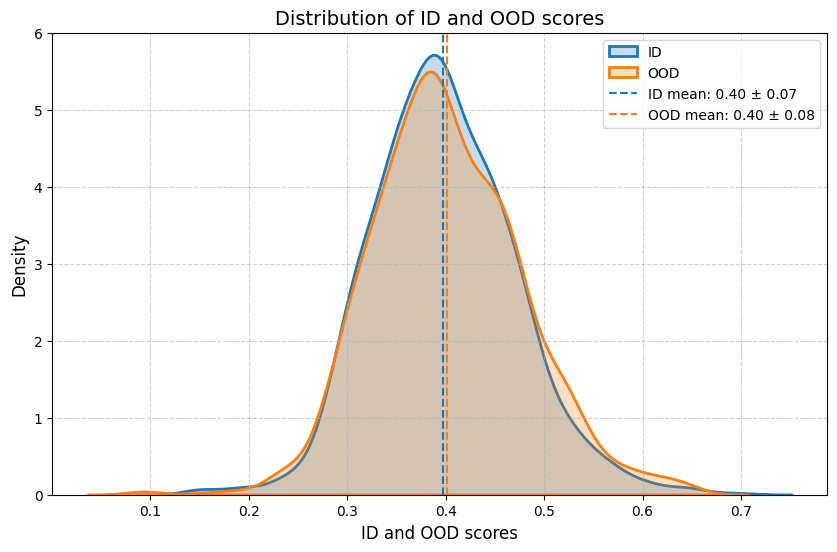

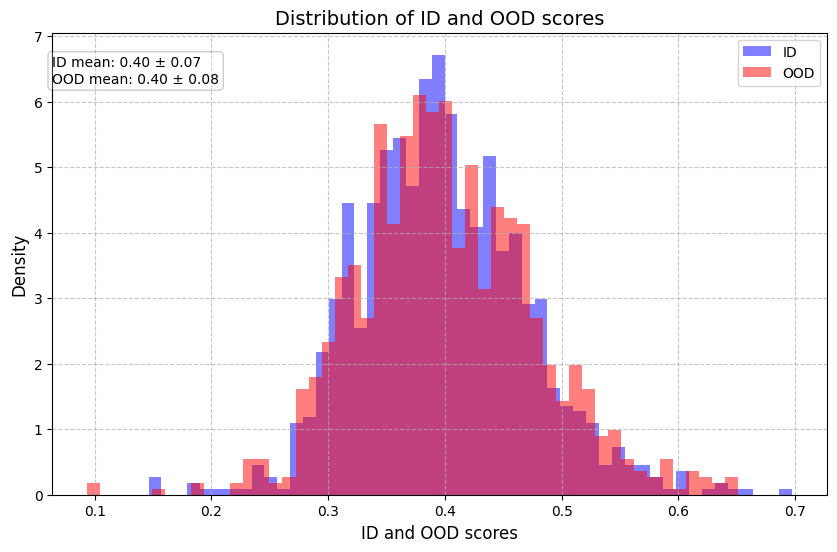

In [22]:
# Plot ID and OOD score distributions 
# -----------------------------------
from src.analysis.visualization import plot_score_distributions_kde, plot_score_distributions_hist
plot_score_distributions_kde(
    scores_id=scores_id,
    scores_ood=scores_ood,
    title="Distribution of ID and OOD scores",
    xlabel="ID and OOD scores"
    #save_path = f"{PLOT_DIR}densities{OUTPUT_TITLE}_k{k}.png"
)

plot_score_distributions_hist(
    scores_id=scores_id,
    scores_ood=scores_ood,
    title="Distribution of ID and OOD scores",
    xlabel="ID and OOD scores"
    #save_path = f"{PLOT_DIR}densities{OUTPUT_TITLE}_k{k}.png"
)

auROC: 0.5110
FPR95: 0.9590
AUC-PR: 0.5174
Optimal Threshold (target_tpr): 0.2889


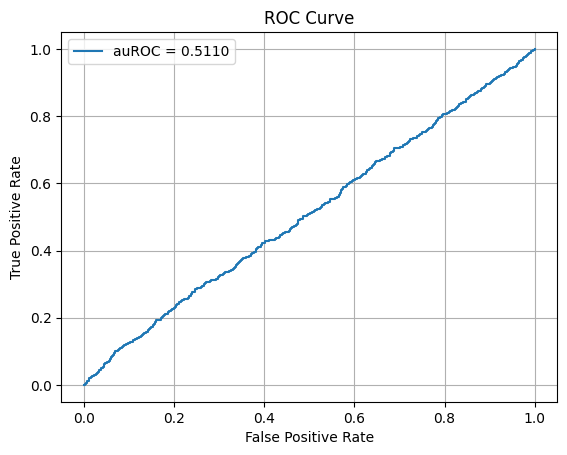

In [23]:
# Compute and plot auroc 
# -----------------------------------
from src.analysis.evaluation import compute_metrics
auroc, fpr95, auc_pr, fpr, tpr, thresholds, selected_threshold = compute_metrics(
    scores_id=scores_id, 
    scores_ood=scores_ood, 
    plot=True,
    threshold_strategy='target_tpr', # 'youden', 'target_tpr'
    target_tpr = 0.95,
    #save_path= f"{PLOT_DIR}roc{OUTPUT_TITLE}_k{k}.png"
)

ᓚ₍ ^. ̫ .^₎

Accuracy: 0.4940
F1 score: 0.6518
Precision: 0.4969
Recall: 0.9470


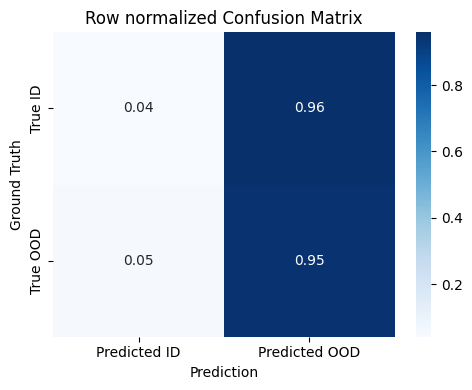

In [25]:
# Generate labels for each test point => 2 possible labels 
# Predicted class is assigned as follows:
#    - score >  threshold -> predicted OOD (label 1)
#    - score <= threshold -> predicted ID (label 0)
# -----------------------------------
# Ground-truth labels: 0=ID, 1=OOD
y_true_thresh = np.concatenate((
    np.zeros(len(scores_id)),
    np.ones(len(scores_ood))
))
# Predicted labels based on threshold: 0=ID, 1=OOD
y_pred_thresh = np.concatenate((
    (scores_id  > selected_threshold).astype(int), 
    (scores_ood > selected_threshold).astype(int)
))

# Result DataFrame: Add 2 class labels (based on Youden's threshold)
# -----------------------------------
df_result['label_2class'] = y_pred_thresh

# Compute confusion matrix
# -----------------------------------
from src.analysis.evaluation import compute_confusion_matrix_and_metrics
cm, accuracy, f1, precision, recall = compute_confusion_matrix_and_metrics(
    y_true=y_true_thresh,
    y_pred=y_pred_thresh,
    plot= True,
    normalize=True,
)

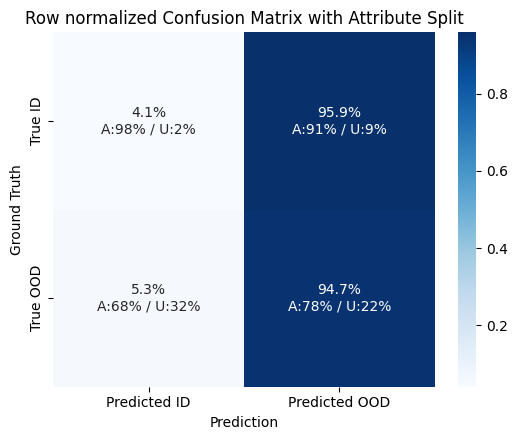

In [26]:
# Plot confusion matrix with unanswerable/answerable split
# -----------------------------------
from src.analysis.evaluation import compute_confusion_matrix_with_attribute_split

compute_confusion_matrix_with_attribute_split(
    y_true=y_true_thresh,
    y_pred=y_pred_thresh,
    attribute=df_result["is_unanswerable"].values,
    attr_labels=("A", "U"), 
    attr_true_value=True,
    normalize=True 
)

#### 2.4. Linear Probing on OOD scores (supervised)

Accuracy: 0.6100
F1 score: 0.5979
Precision: 0.6170
Recall: 0.5800


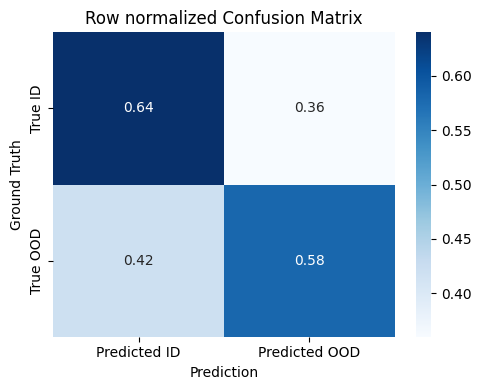

In [27]:
# Perform logistic regression 
# -----------------------------------
from src.analysis.evaluation import compute_confusion_matrix_and_metrics
from src.ood_methods.logistic_regression import train_logistic_regression_on_descriptors
from src.analysis.analyze_ood_results import ensure_2d

clf, y_true_probe, y_pred_probe, idx_test = train_logistic_regression_on_descriptors(
    ensure_2d(id_test_descriptors), ensure_2d(od_test_descriptors), random_state=SEED, test_size=0.1
)
cm, accuracy, f1, precision, recall = compute_confusion_matrix_and_metrics(
    y_true=y_true_probe,
    y_pred=y_pred_probe,
    plot=True,
    normalize=True,
) 

# Result DataFrame: Add labels predicted by logistic regression
# -----------------------------------
df_result['label_probing'] = np.nan  # init with NaN
df_result.loc[idx_test, 'label_probing'] = y_pred_probe.astype(int)

### 3. Visualize one configuration

In [28]:
# Plot PCA, t-SNE and UMAP of unclassified samples  
# NOTE: only available for 2D embedding descriptors (will produce error for 1D descriptors)
# -----------------------------------
from src.analysis.visualization import plot_dim_reduction_3d_embeddings

pca_config = {'n_components': 3}
tsne_config = {'n_components': 3, 'perplexity': 50}
umap_config = {'n_components': 3, 'n_neighbors': 15, 'min_dist': 0.1}

# --- PCA only ---
_ = plot_dim_reduction_3d_embeddings(
    id_test_embeddings=id_test_descriptors, #[N,D]
    od_test_embeddings=od_test_descriptors, 
    labels_id=None, 
    labels_ood=None,
    pca_config=pca_config
)

# --- t-SNE only ---
'''
_ = plot_dim_reduction_3d_embeddings(
    id_test_embeddings=id_test_descriptors, 
    od_test_embeddings=od_test_descriptors, 
    labels_id=None, 
    labels_ood=None,
    tsne_config=tsne_config
)

# --- UMAP only ---
_ = plot_dim_reduction_3d_embeddings(
    id_test_embeddings=id_test_descriptors, 
    od_test_embeddings=od_test_descriptors, 
    labels_id=None, 
    labels_ood=None,
    umap_config=umap_config
)
'''

'\n_ = plot_dim_reduction_3d_embeddings(\n    id_test_embeddings=id_test_descriptors, \n    od_test_embeddings=od_test_descriptors, \n    labels_id=None, \n    labels_ood=None,\n    tsne_config=tsne_config\n)\n\n# --- UMAP only ---\n_ = plot_dim_reduction_3d_embeddings(\n    id_test_embeddings=id_test_descriptors, \n    od_test_embeddings=od_test_descriptors, \n    labels_id=None, \n    labels_ood=None,\n    umap_config=umap_config\n)\n'

In [29]:
# Generate labels for each test point => 4 possible labels 
# -----------------------------------
'''
Class 0: ID well classified  (true ID,  score < threshold)
Class 1: OOD well classified (true OOD, score > threshold)
Class 2: OOD not detected    (true OOD, score < threshold)
Class 3: ID not detected     (true ID,  score > threshold)
'''
# Assumes that : Low score => ID, High score => OOD
labels_id_thresh  = np.where(scores_id  < selected_threshold, 0, 3)   # 0: ID correct, 3: ID not detected
labels_ood_thresh = np.where(scores_ood > selected_threshold, 1, 2)   # 1: OOD correct, 2: OOD not detected

# Result DataFrame: Add 4 class labels (well/wrongly classified)
# -----------------------------------
df_result['label_4class'] = np.concatenate([labels_id_thresh, labels_ood_thresh])

In [30]:
# Plot PCA, t-SNE and UMAP of classified samples  
# NOTE: only available for 2D embedding descriptors (will produce error for 1D descriptors)
# -----------------------------------
from src.analysis.visualization import plot_dim_reduction_3d_embeddings

pca_config = {'n_components': 3}
tsne_config = {'n_components': 3, 'perplexity': 100}
umap_config = {'n_components': 3, 'n_neighbors': 15, 'min_dist': 0.1}

# --- PCA only ---
_ = plot_dim_reduction_3d_embeddings(
    id_test_embeddings=id_test_descriptors, 
    od_test_embeddings=od_test_descriptors, 
    labels_id=labels_id_thresh, 
    labels_ood=labels_ood_thresh, 
    pca_config=pca_config
)

In [39]:
od_test_data['descriptors']['layer_1']['logit'].keys()

dict_keys(['perplexity_score', 'logit_entropy_score', 'window_logit_entropy_score'])

### 4. Find best config

In [44]:
# Evaluate all available (layer, group, aggregation) configurations using the chosen OOD method.
# -----------------------------------
from src.analysis.analyze_ood_results import grid_search_best_config

df_res = grid_search_best_config(
    id_fit_data=id_fit_data,
    id_test_data=id_test_data,
    od_test_data=od_test_data,
    method="dknn", # "dknn", "cosine", "mahalanobis", "ocsvm", "isoforest" --> DO NOT PUT "raw_scores" (managed internally)
    method_params=config_dknn,
    probing_test_size=0.1,
    probing_random_state=SEED,
    show_progress=True,
    save_path=PLOT_DIR + f'ood_grid_{ACTIVATION_SOURCE}_seed{SEED}.xlsx',
    threshold_strategy='target_tpr', # 'youden', 'target_tpr'
    target_tpr= 0.95,
    sort_by=['auroc','acc_probe'],
    ascending=None,
    debug=False
)

Layers: 100%|██████████| 16/16 [03:06<00:00, 11.68s/it]


### Bootstrap analysis: determine optimal number of samples for best result

In [27]:
# ===================================
# Perform bootstrap analysis to determine the optimal 
# number of samples to obtain the best result
# ===================================
from src.analysis.bootstrap import bootstrap_analysis

# Define sample size ranges to be tested
# -----------------------------------
n_fit_samples_range = [10_000, 20_000, 40_000, 60_000, 70_000, 80_000]
n_test_samples_range = [1_000, 2_000, 4_000, 7_000, 8_000]

# Compute bootstrap analysis
# -----------------------------------
bootstrap_results = bootstrap_analysis(
    id_fit_embeddings=id_fit_descriptors,
    id_test_embeddings=id_test_descriptors,
    od_test_embeddings=od_test_descriptors,
    n_fit_samples=n_fit_samples_range,
    n_test_samples=n_test_samples_range,
    compute_ood_score_fn=compute_dknn_scores, ### MUST BE ADAPTED DESCRIPTORS DIFFERENT THAN EMBEDDINGS
    n_bootstrap=50, 
    **config
)


Starting bootstrap analysis...


Fit samples:   0%|          | 0/6 [00:00<?, ?it/s]

Fit samples: 100%|██████████| 6/6 [36:36<00:00, 366.05s/it]


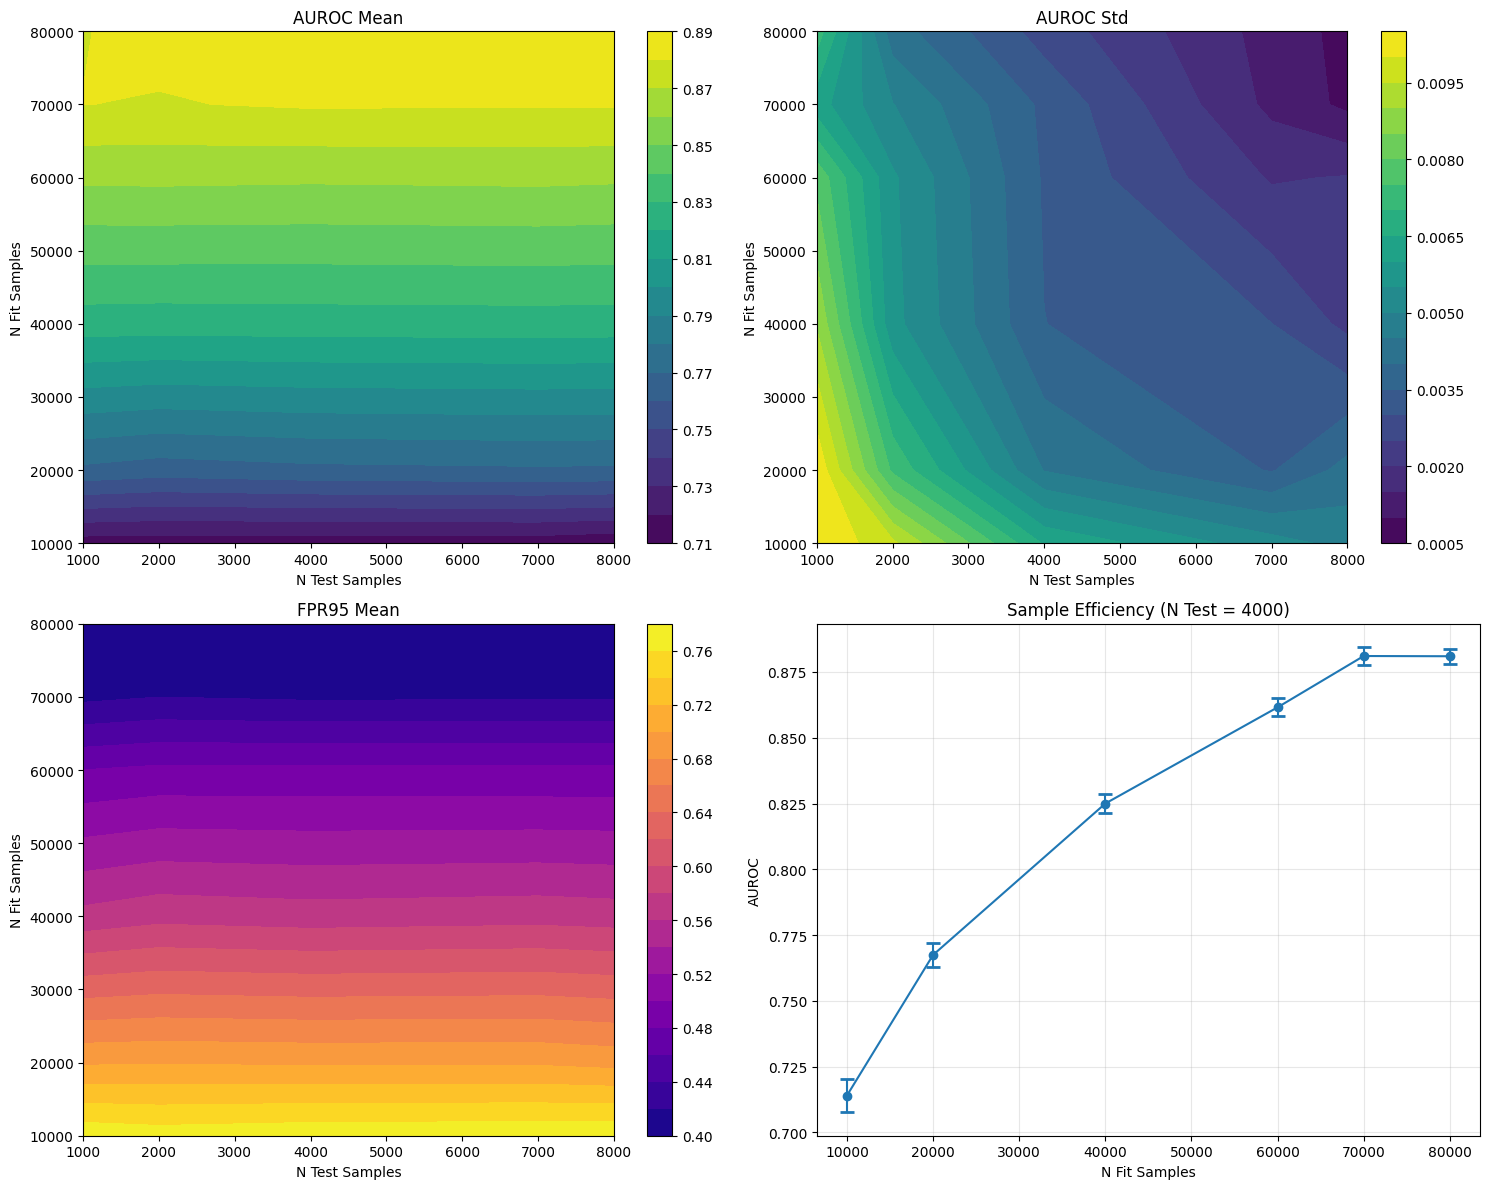


FINAL RESULTS

Bootstrap Analysis (averages over 6×5 configurations):
AUROC: 0.822 ± 0.005
AUPRC: 0.798 ± 0.006
FPR95: 0.560 ± 0.014

RECOMMENDATIONS

Optimal configuration found:
  - Fit samples: 80000
  - Test samples: 2000
  - AUROC: 0.882 ± 0.004

Saturation analysis:
  - With 10000 fit samples: AUROC = 0.822
  - With 80000 fit samples: AUROC = 0.821


In [29]:
# Visualize bootstrap analysis
# -----------------------------------
from src.analysis.bootstrap import plot_bootstrap_results, display_bootstrap_statistics

plot_bootstrap_results(bootstrap_results, save_path=f"{PLOT_DIR}bootstrap_analysis{OUTPUT_TITLE}.png")

display_bootstrap_statistics(bootstrap_results, n_fit_samples_range, n_test_samples_range)

# Brouillon

### Find best config

In [7]:
from __future__ import annotations

from typing import Dict, Tuple, Optional, Any, List
import numpy as np
import torch
from tqdm import tqdm

from src.analysis.evaluation import compute_metrics, compute_confusion_matrix_and_metrics
from src.ood_methods.logistic_regression import train_logistic_regression_on_descriptors

# --- Imports classiques des méthodes OOD ---
from src.ood_methods.dknn import compute_dknn_scores
from src.ood_methods.cosine import compute_cosine_similarity
from src.ood_methods.mahalanobis import compute_mahalanobis_distance
from src.ood_methods.ocsvm import compute_ocsvm_score
from src.ood_methods.isoforest import isolation_forest




In [8]:
# Load ID embeddings 
# -----------------------------------
from src.data_reader.pickle_io import load_pickle_batches
from src.utils.general import add_unanswerable_flag, filter_entries

# Load extracted embeddings 
id_fit_data = load_pickle_batches(f"{OUTPUT_DIR}id_fit_results{OUTPUT_TITLE}.pkl")

# Add unanswerable flag: check if the generated answer contains 'unanswerable' keyword
# Expect many 'unanswerable' flags in `od_test_data` and few in `id_test_data`, if model works well
id_fit_data = add_unanswerable_flag(id_fit_data)

Loaded 8008 samples from: ../results/raw/small_dataset_correct_split_allScores/id_fit_results_layer1:32:2_score_all_hidden_attn_logit_prompt_so0_eo0.pkl


In [9]:
# Load test embeddings 
# -----------------------------------
from src.data_reader.pickle_io import load_pickle_batches
from src.utils.general import add_unanswerable_flag, filter_entries

# Load extracted possible and impossible embeddings 
od_test_data = load_pickle_batches(f"{OUTPUT_DIR}od_test_results{OUTPUT_TITLE}.pkl")
id_test_data = load_pickle_batches(f"{OUTPUT_DIR}id_test_results{OUTPUT_TITLE}.pkl")

# Add unanswerable flag: check if the generated answer contains 'unanswerable' keyword
# Expect many 'unanswerable' flags in `od_test_data` and few in `id_test_data`, if model works well
od_test_data = add_unanswerable_flag(od_test_data)
id_test_data = add_unanswerable_flag(id_test_data)

Loaded 1000 samples from: ../results/raw/small_dataset_correct_split_allScores/od_test_results_layer1:32:2_score_all_hidden_attn_logit_prompt_so0_eo0.pkl
Loaded 1000 samples from: ../results/raw/small_dataset_correct_split_allScores/id_test_results_layer1:32:2_score_all_hidden_attn_logit_prompt_so0_eo0.pkl


In [10]:
# =============================================================================
# Configuration discovery
# =============================================================================
def discover_config_space(data_dict: Dict[str, Any]) -> Dict[str, Any]:
    """
    Discover the available configuration space directly from the key `descriptors` 
    from the data_dict dictionary

    Parameters
    ----------
    data_dict : Dict[str, Any]
        One split's dictionary containing the `descriptors` key with the structure: 
        {
            "descriptors": {
                "layer_{i}": {
                    "hidden": {
                        "<hidden_agg>": np.ndarray[(n_samples, feat_dim), float]
                                     or np.ndarray[(n_samples,), float]
                        ...
                    },
                    "attention": {
                        "<attn_agg>": np.ndarray[(n_samples,), float]
                        ...
                    },
                    "logit": {
                        "<logit_agg>": np.ndarray[(n_samples,), float]
                        ...
                    }
                },
            }
        }

    Returns
    -------
    space : Dict[str, Any]
        {
          "layers": List[int],
          "hidden_aggs_by_layer": Dict[int, List[str]],
          "attn_aggs_by_layer": Dict[int, List[str]],
          "logits_aggs_by_layer": Dict[int, List[str]]
        }

    """
    assert "descriptors" in data_dict, "data_dict must contain key 'descriptors'."
    S = data_dict["descriptors"]

    # Extract layer indices from keys like "layer_12"
    layers: List[int] = []
    for k in S.keys():
        if k.startswith("layer_"):
            try:
                layers.append(int(k.split("_", 1)[1]))
            except Exception:
                pass
    layers = sorted(set(layers))

    hidden_aggs_by_layer: Dict[int, List[str]] = {}
    attn_aggs_by_layer: Dict[int, List[str]] = {}
    logits_aggs_by_layer: Dict[int, List[str]] = {}

    for li in layers:
        layer_node = S.get(f"layer_{li}", {})

        # Hidden aggregations: 2D descriptors (n_samples, feat_dim)
        hidden_aggs_by_layer[li] = (
            sorted(list(layer_node.get("hidden", {}).keys()))
            if isinstance(layer_node.get("hidden"), dict) else []
        )

        # Attention "scores": 1D descriptors (n_samples,)
        attn_aggs_by_layer[li] = (
            sorted(list(layer_node.get("attention", {}).keys()))
            if isinstance(layer_node.get("attention"), dict) else []
        )

        # Logits "scores": 1D descriptors (n_samples,)
        logits_aggs_by_layer[li] = (
            sorted(list(layer_node.get("logit", {}).keys()))
            if isinstance(layer_node.get("logit"), dict) else []
        )

    return {
        "layers": layers,
        "hidden_aggs_by_layer": hidden_aggs_by_layer,
        "attn_aggs_by_layer": attn_aggs_by_layer,
        "logits_aggs_by_layer": logits_aggs_by_layer,
    }


In [27]:
space = discover_config_space(id_fit_data)

In [11]:
# =============================================================================
# Descriptor extraction
# =============================================================================
def retrieve_one_config_from_dict(
    data_dict: Dict[str, Any],
    layer: int,
    group: str,
    aggregation: str
) -> np.ndarray:
    """
    Extract descriptors (e.g., embeddings or other features
    derived from hidden representations) for a given configuration:
    layer, group and aggregation

    Parameters
    ----------  
    data_dict : Dict[str, Any]
        One split's dictionary containing the `descriptors` key with the structure: 
        {
            "descriptors": {
                "layer_{i}": {
                    "hidden": {
                        "<hidden_agg>": np.ndarray[(n_samples, feat_dim), float]
                                     or np.ndarray[(n_samples,), float]
                        ...
                    },
                    "attention": {
                        "<attn_agg>": np.ndarray[(n_samples,), float]
                        ...
                    },
                    "logit": {
                        "<logit_agg>": np.ndarray[(n_samples,), float]
                        ...
                    }
                },
            }
        }
    layer : int
        Layer index to read from (applies to `hidden`, `attention`, `logit`).
    group : str
        One of {"hidden", "attention", "logit"}.
    aggregation : str
        Name of the aggregation mode within the chosen group.
        One of  {"perplexity_score", "logit_entropy_score", "window_logit_entropy_score"} from "logit" group, 
                {"avg_emb", "last_emb", "max_emb", "first_gen_emb", "feat_var_emb", "hidden_score"} from "hidden" group 
                {"attn_score"} from "attention" group

    Returns
    -------
    arr : np.ndarray[float]
        - If aggregation mode ends with '*_emb': shape (n_samples, feat_dim), float
        - If aggregation mode ends with '*_score': shape (n_samples), float

    Raises
    ------
    KeyError
        If the requested path does not exist in the dictionary.
    """
    
    S = data_dict["scores"]
    layer_node = S.get(f"layer_{layer}", {})

    if group == "hidden":
        if "hidden" in layer_node and aggregation in layer_node["hidden"]:
            return np.asarray(layer_node["hidden"][aggregation])
        raise KeyError(f"Missing hidden '{aggregation}' for layer {layer}")

    if group == "attention":
        if "attention" in layer_node and aggregation in layer_node["attention"]:
            return np.asarray(layer_node["attention"][aggregation])
        raise KeyError(f"Missing attention '{aggregation}' for layer {layer}")
    
    if group == "logit":
        if "logit" in layer_node and aggregation in layer_node["logit"]:
            return np.asarray(layer_node["logit"][aggregation])
        raise KeyError(f"Missing logit '{aggregation}' for layer {layer}")

    raise ValueError(f"Unknown group: {group}. Expected 'hidden' | 'attention' | 'logit'.")

In [29]:
LAYER = -1
GROUP = 'logits'
AGGREGATION = 'perplexity'

id_fit_descriptors = retrieve_one_config_from_dict(id_fit_data, layer=LAYER, group=GROUP, aggregation=AGGREGATION)
id_test_descriptors = retrieve_one_config_from_dict(id_test_data, layer=LAYER, group=GROUP, aggregation=AGGREGATION)
od_test_descriptors = retrieve_one_config_from_dict(od_test_data, layer=LAYER, group=GROUP, aggregation=AGGREGATION)

In [17]:
config_dknn = {'k': 5, 'batch_size': BATCH_SIZE} # DKNN config
config_cosine = {'center_type':'all', 'seed': SEED, 'k': 5, 'batch_size': BATCH_SIZE} # Cosine Similarity config
config_maha = {'center_type':'mean', 'seed': SEED, 'k': 5} # Mahalanobis config
config_ocsvm = {'kernel':'rbf', 'nu': 0.1, 'gamma': 'scale'} # OCSVM config
config_isoforest = {'n_estimators':1000, 'contamination': 'auto', 'seed': SEED} # Isolation forest config


In [30]:
scores_id, scores_ood = compute_ood_scores(
    method='raw_scores',
    id_fit_descriptors=id_fit_descriptors,
    id_test_descriptors=id_test_descriptors,
    od_test_descriptors=od_test_descriptors,
    **config_ocsvm
)

In [20]:
def _describe_array(
    name: str,
    X,
    eps: float = 1e-12,
    near_eps: float = 1e-8,
    uniq_round_decimals: int = 6,
    uniq_sample_rows: int = 2048,
) -> None:
    """
    Print diagnostics on an array/tensor:
      - shape, fraction of non-finite, 'zero-like' fraction (rows with ~zero norm for 2D or values ~0 for 1D)
      - mean/std/min/max over finite values
      - near-identical check:
          * 2D: fraction of features with near-zero std across samples,
                approximate unique-rows fraction after rounding (on a subset)
          * 1D: approximate unique-values fraction after rounding
    """
    Xnp = np.asarray(X)
    finite_mask = np.isfinite(Xnp)
    # upcast for stable stats
    Xf = np.where(finite_mask, Xnp, np.nan).astype(np.float64, copy=False)

    # zero-like fraction
    if Xnp.ndim == 1:
        frac_zero_like = float(np.nanmean(np.abs(Xf) <= eps))
    elif Xnp.ndim == 2:
        Xsafe = np.where(finite_mask, Xnp, 0.0).astype(np.float64, copy=False)
        norms = np.linalg.norm(Xsafe, axis=1)
        frac_zero_like = float(np.mean(norms <= eps))
    else:
        frac_zero_like = float(np.nanmean(np.abs(Xf) <= eps))

    # global stats on finite values
    nonfinite_frac = float(1.0 - np.mean(finite_mask))
    mean_f = float(np.nanmean(Xf))
    std_f  = float(np.nanstd(Xf))
    min_f  = float(np.nanmin(Xf))
    max_f  = float(np.nanmax(Xf))

    # near-identical diagnostics
    near_flag = False
    near_msg = ""
    if Xnp.ndim == 2 and Xnp.shape[0] > 1:
        # variability across samples (per-feature std)
        feat_std = np.nanstd(Xf, axis=0)
        mean_feat_std = float(np.nanmean(feat_std))
        frac_low_var_feats = float(np.mean(feat_std <= near_eps))

        # approximate unique-rows fraction (on finite subset, rounded)
        N = min(Xnp.shape[0], uniq_sample_rows)
        sub = Xf[:N]
        row_finite = np.all(np.isfinite(sub), axis=1)
        sub = sub[row_finite]
        if sub.size > 0:
            sub_rounded = np.round(sub, uniq_round_decimals)
            unique_rows = np.unique(sub_rounded, axis=0).shape[0]
            unique_frac = float(unique_rows / max(sub_rounded.shape[0], 1))
        else:
            unique_frac = 0.0

        near_flag = (mean_feat_std <= near_eps) or (frac_low_var_feats >= 0.99) or (unique_frac <= 0.01)
        near_msg = (
            f" | mean_feat_std={mean_feat_std:.3e} "
            f"low_var_feats={frac_low_var_feats:.2%} "
            f"unique_rows_frac≈{unique_frac:.4f} "
            f"near_identical_rows≈{near_flag}"
        )

    elif Xnp.ndim == 1 and Xnp.size > 1:
        N = min(Xnp.size, uniq_sample_rows)
        sub = Xf[:N]
        sub = sub[np.isfinite(sub)]
        if sub.size > 0:
            sub_rounded = np.round(sub, uniq_round_decimals)
            unique_vals = np.unique(sub_rounded).size
            unique_frac = float(unique_vals / max(sub_rounded.size, 1))
        else:
            unique_frac = 0.0

        near_flag = (std_f <= near_eps) or (unique_frac <= 0.01)
        near_msg = f" | unique_vals_frac≈{unique_frac:.4f} near_identical_vals≈{near_flag}"

    print(
        f"{name} shape={Xnp.shape} "
        f"nonfinite={nonfinite_frac:.4f} zero_like={frac_zero_like:.4f} "
        f"mean={mean_f:.6f} std={std_f:.6f} min={min_f:.6f} max={max_f:.6f}"
        f"{near_msg}"
    )


In [13]:
print("="*30)

In [12]:
from pathlib import Path
from typing import Literal
from src.analysis.analyze_ood_results import discover_config_space, retrieve_one_config_from_dict
from src.ood_methods.ood_main import compute_ood_scores
 
# =============================================================================
# Full grid over available configs
# =============================================================================
def grid_search_best_config(
    id_fit_data: Dict[str, Any],
    id_test_data: Dict[str, Any],
    od_test_data: Dict[str, Any],
    method: str = "dknn",
    method_params: Optional[Dict[str, Any]] = None,
    probing_test_size: float = 0.2,
    probing_random_state: int = 42,
    show_progress: bool = True,
    save_path: Optional[str] = None,  
    threshold_strategy: Literal["youden", "target_tpr"] = "youden",
    target_tpr: float = 0.95,
    sort_by: Optional[List[str]] = None,
    ascending: Optional[List[bool]] = None,
    debug: bool = False,
) -> pd.DataFrame:
    """
    Enumerate and evaluate all available (layer, group, aggregation) configurations
    discovered from the `descriptors` keys in dicts id_fit_data/id_test_data/od_test_data,
    using the chosen OOD method.

    For each configuration, this function:
      1) Extracts descriptors for ID fit / ID test / OOD test.
      2) Computes OOD scores (ID vs OOD) using `method`.
      3) Computes ROC metrics (AUROC, FPR95, AUPRC) and selects a decision threshold
         using `threshold_strategy`:
           - 'youden'     : maximizes Youden's J = TPR - FPR
           - 'target_tpr' : picks the threshold whose TPR is closest to `target_tpr`
      4) Thresholds predictions (ID=0 / OOD=1) at the selected threshold and reports
         accuracy/F1/precision/recall.
      5) Runs **linear probing** (logistic regression) on the descriptors themselves
         and reports accuracy/F1/precision/recall for the probe.

    Parameters
    ----------
    id_fit_data : Dict[str, Any]
        ID fit split with the `descriptors` key structure.           
    id_test_data : Dict[str, Any]
        ID test split with the`descriptors` key structure.     
    od_test_data : Dict[str, Any]
        OOD test split with the `descriptors` key structure.  
    method : str, optional (default="dknn")
        OOD method. One of:
          "dknn", "cosine", "mahalanobis", "ocsvm", "isoforest".
        - Method is forced internally to "raw_scores" when descriptors are already
          scalar scores (1D). In that case, we take the raw scores as OOD scores.
    method_params : Optional[Dict[str, Any]], optional
        Extra keyword arguments for the chosen method (e.g., k=1 for DKNN).
        Optional metadata (e.g., "prompt" | "generation" | "PromptGeneration").
        Stored in the resulting DataFrame for traceability.
    probing_test_size : float, optional (default=0.2)
        Test split proportion used inside the logistic-regression probing.
    probing_random_state : int, optional (default=42)
        Random seed for the logistic-regression probing split.
    show_progress : bool, optional (default=True)
        If True, display tqdm progress bars.
    threshold_strategy : {"youden","target_tpr"}, default "youden"
        Strategy to select the operating threshold from ROC.
    target_tpr : float, default 0.95
        Target TPR used when `threshold_strategy="target_tpr"`.
    sort_by : Optional[List[str]], default None
        Column(s) to sort the final DataFrame by. If None, defaults to
        ["auroc", "auprc"] in descending order when possible.
    ascending : Optional[List[bool]], default None
        Sort order per `sort_by`. Can be a single bool or a list with the same
        length as `sort_by`. If None and `sort_by` is provided, defaults to all False
        (i.e., descending for each column).
    debug : bool, default False
        If True, print small descriptive stats for each descriptor array.

    
    Note
    ----
    id_fit_data, id_test_data and od_test_data have the following structure: 
        {
            "descriptors": {
                "layer_{i}": {
                    "hidden": {
                        "<hidden_agg>": np.ndarray[(n_samples, feat_dim), float]
                                     or np.ndarray[(n_samples,), float]
                        ...
                    },
                    "attention": {
                        "<attn_agg>": np.ndarray[(n_samples,), float]
                        ...
                    },
                    "logit": {
                        "<logit_agg>": np.ndarray[(n_samples,), float]
                        ...
                    }
                },
            }
        }

    Returns
    -------
    df_results : pd.DataFrame
        One row per (layer, group, aggregation) configuration with columns:
        - "layer": int
        - "group": str  in {"hidden", "attention", "logit"}
        - "aggregation": str  (e.g., "avg_emb", "attn_score", "logit_entropy_score", ...)
        - "method": str
        - "method_params": Dict[str, Any]

        OOD-score thresholding:
        - "auroc": float
        - "fpr95": float
        - "auprc": float
        - "threshold": float  (selected per strategy)
        - "acc_thresh": float
        - "f1_thresh": float
        - "prec_thresh": float
        - "recall_thresh": float

        Linear probing (logistic regression on descriptors):
        - "acc_probe": float
        - "f1_probe": float
        - "prec_probe": float
        - "recall_probe": float

    Notes
    -----
    - Descriptor shapes:
        hidden   -> (n_samples, feat_dim)  (2D)
        attention/logits -> (n_samples,)   (1D), reshaped to (n_samples, 1) for probing.
    - OOD score convention: higher score means "more OOD".
    - For the first_generated + prompt configuration, it's expected that all embeddings end up 
      (nearly) identical. Because the first generated token in the prompt is always the BOS/special 
      token (e.g., <s>). Since every sample shares the same first token, its representation is the 
      same across the dataset. As a result, distance-based  OOD scores (DKNN, cosine, etc.) collapse 
      to zero for everyone, and the method has no discriminative power in this setting.
    """
    method_params = method_params or {}

    # Retrieve all space configurations
    space = discover_config_space(id_fit_data)

    # Convenience for optional progress bars
    LayerIter = tqdm(space["layers"], desc="Layers") if show_progress else space["layers"]

    rows: List[Dict[str, Any]] = []

    # Helper: evaluate one configuration and append a row
    def _evaluate_and_append_row(
        layer: int,
        group: str,
        agg: str,
        method: str,
    ) -> None:
        
        # Descriptor extraction for a given configuration
        fit = retrieve_one_config_from_dict(id_fit_data, layer, group, agg)
        idt = retrieve_one_config_from_dict(id_test_data, layer, group, agg)
        odt = retrieve_one_config_from_dict(od_test_data, layer, group, agg)

        # Check if descriptors are 1D scores. In that case, use 
        # them directly as OOD scores and do not apply OOD methods
        if fit.ndim==1:
            method='raw_scores'

        # OOD scores (ID vs OOD)
        scores_id, scores_ood = compute_ood_scores(
            method=method,
            id_fit_descriptors=fit,  # shape: (n_fit,d) or (n_fit,)
            id_test_descriptors=idt, # shape: (n_idt,d) or (n_idt,)
            od_test_descriptors=odt, # shape: (n_odt,d) or (n_odt,)
            **method_params
        )

        if debug:
            print("="*30)
            for name, X in [("fit", fit), ("id", idt), ("ood", odt)]:
                _describe_array(name, X)


        # ROC metrics + threshold
        auroc, fpr95, auc_pr, fpr, tpr, thresholds, selected_threshold = compute_metrics(
            scores_id=scores_id, scores_ood=scores_ood, plot=False, save_path=None,
            threshold_strategy=threshold_strategy, target_tpr=target_tpr,
        )

        # Generate labels for each test point with Thresholding 
        # Predicted class is assigned as follows:
        # - score >  threshold -> predicted OOD (label 1)
        # - score <= threshold -> predicted ID (label 0)
        y_true = np.concatenate(   # Ground-truth labels: 0=ID, 1=OOD
            [np.zeros(len(scores_id), dtype=int), np.ones(len(scores_ood), dtype=int)]
        )
        y_pred = np.concatenate(   # Predicted labels based on threshold: 0=ID, 1=OOD
            [(scores_id > selected_threshold).astype(int), (scores_ood > selected_threshold).astype(int)]
        ) 

        _, acc, f1, prec, rec = compute_confusion_matrix_and_metrics(
            y_true=y_true, y_pred=y_pred, plot=False, normalize=True
        )

        if debug:
            print("unique y_true:", np.unique(y_true, return_counts=True))
            print("unique y_pred:", np.unique(y_pred, return_counts=True))
            print("used threshold:", selected_threshold)
        

        # Linear probing on descriptors; reshape 1D to 2D for probing
        def ensure_2d(X: np.ndarray) -> torch.Tensor:
            '''if X.shape==(n,) -> becomes (n,1);  if X.shape==(n,d) -> unchanged
            if X.shape==(n,1) -> unchanged
            '''
            X = np.asarray(X)
            if X.ndim == 1:
                X = X.reshape(-1, 1)
            return torch.from_numpy(X) 

        clf, y_test_probe, y_pred_probe, idx_test = train_logistic_regression_on_descriptors(
            id_test_descriptors=ensure_2d(idt), 
            od_test_descriptors=ensure_2d(odt),
            random_state=probing_random_state,
            test_size=probing_test_size
        )
        _, acc_p, f1_p, prec_p, rec_p = compute_confusion_matrix_and_metrics(
            y_true=y_test_probe, y_pred=y_pred_probe, plot=False, normalize=True
        )


        rows.append({
            "layer": layer,
            "group": group,
            "aggregation": agg,
            "method": method,
            "method_params": dict(method_params),

            "auroc": float(auroc),
            "fpr95": float(fpr95),
            "auprc": float(auc_pr),
            "threshold": float(selected_threshold),

            "acc_thresh": float(acc),
            "f1_thresh": float(f1),
            "prec_thresh": float(prec),
            "recall_thresh": float(rec),

            "acc_probe": float(acc_p),
            "f1_probe": float(f1_p),
            "prec_probe": float(prec_p),
            "recall_probe": float(rec_p),
        })

    # -------------------------
    # Hidden (per layer, 2D)
    # -------------------------
    for layer in LayerIter:
        
        hidden_aggs = space["hidden_aggs_by_layer"].get(layer, [])
        if show_progress:
            hidden_aggs = tqdm(hidden_aggs, desc=f"Hidden aggs @ layer {layer}", leave=False)
        for agg in hidden_aggs:
            #print(f"\naggregation {agg}")
            _evaluate_and_append_row(layer, "hidden", agg, method)

        # -------------------------
        # Attention (per layer, 1D)
        # -------------------------
        attn_aggs = space["attn_aggs_by_layer"].get(layer, [])
        if show_progress:
            attn_aggs = tqdm(attn_aggs, desc=f"Attention aggs @ layer {layer}", leave=False)
        for agg in attn_aggs:
            #print(f"\naggregation {agg}")
            _evaluate_and_append_row(layer, "attention", agg, method)

        # -------------------------
        # Logits (per layer, 1D)
        # -------------------------
        logits_aggs = space["logits_aggs_by_layer"].get(layer, [])
        if show_progress:
            logits_aggs = tqdm(logits_aggs, desc=f"Logits aggs @ layer {layer}", leave=False)
        for agg in logits_aggs:
            #print(f"\naggregation {agg}")
            _evaluate_and_append_row(layer, "logits", agg, method)


    # -------------------------
    # Build & sort DataFrame
    # -------------------------
    df = pd.DataFrame(rows)
    if not df.empty:  # Sort if there is at least one row.
        if sort_by is None:
            sort_cols = ["auroc", "auprc"] # Default sort keys
            sort_ord = [False, False]  # Sort in descending order
        else:
            # Normalize `sort_by` into a list (accept a single string or a list/tuple of strings).
            sort_cols = list(sort_by) if isinstance(sort_by, (list, tuple)) else [sort_by]  
            if ascending is None:
                # If no `ascending` is provided, default to descending for each sort column.
                sort_ord = [False] * len(sort_cols)
            elif isinstance(ascending, bool):
                # If a single bool is provided, broadcast it to all sort columns.
                sort_ord = [ascending] * len(sort_cols)
            else:
                # If a list/tuple is provided, it must match the length of `sort_cols`.
                if len(ascending) != len(sort_cols):
                    raise ValueError("`ascending` must be a bool or a list with the same length as `sort_by`.")
                sort_ord = list(ascending) # Make a shallow copy as a list.

            # Keep only sort columns that actually exist in the DataFrame (avoids KeyError).
            present = [c for c in sort_cols if c in df.columns]
            if len(present) < len(sort_cols):
                # If we dropped some columns, drop their corresponding sort orders to keep alignment.
                sort_ord = [ord for c, ord in zip(sort_cols, sort_ord) if c in present]
                sort_cols = present

        if sort_cols: # If there is at least one valid column to sort on, sort the DataFrame 
            df = df.sort_values(sort_cols, ascending=sort_ord).reset_index(drop=True)

    # Build DataFrame and sort by AUROC (desc) then AUPRC (desc)
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values(["auroc", "auprc"], ascending=[False, False]).reset_index(drop=True)

    # -------------------------
    # Save results if requested
    # -------------------------
    if save_path is not None:
        dirpath = os.path.dirname(save_path)
        if dirpath:
            os.makedirs(dirpath, exist_ok=True)
        df.to_csv(save_path, index=False)

    return df

In [ ]:
df_res = grid_search_ood_configs(
    id_fit_data=id_fit_data,
    id_test_data=id_test_data,
    od_test_data=od_test_data,
    method="dknn", # DO NOT PUT "raw_scores"
    method_params=config_dknn,
    probing_test_size=0.2,
    probing_random_state=777,
    show_progress=True,
    save_path=PLOT_DIR + f'ood_grid_{ACTIVATION_SOURCE}.csv',
)

Layers:   0%|          | 0/16 [00:00<?, ?it/s]

Layers: 100%|██████████| 16/16 [02:44<00:00, 10.30s/it]


In [ ]:
# trier par ordre 

In [19]:
df_res

,activation_source,layer,group,aggregation,method,method_params,auroc,fpr95,auprc,threshold,acc_thresh,f1_thresh,prec_thresh,recall_thresh,acc_probe,f1_probe,prec_probe,recall_probe
0,generation,13,hidden,last,dknn,"{'k': 5, 'batch_size': 16}",0.574773,0.890,0.550238,0.029199,0.5600,0.609236,0.547923,0.686,0.7700,0.768844,0.772727,0.765
1,generation,15,hidden,last,dknn,"{'k': 5, 'batch_size': 16}",0.571870,0.887,0.543901,0.021058,0.5600,0.655172,0.538660,0.836,0.7700,0.767677,0.775510,0.760
2,generation,17,hidden,last,dknn,"{'k': 5, 'batch_size': 16}",0.571711,0.890,0.544259,0.022082,0.5615,0.639836,0.542857,0.779,0.7800,0.783251,0.771845,0.795
3,generation,23,logits,perplexity,raw_scores,"{'k': 5, 'batch_size': 16}",0.538009,0.942,0.533549,1872.226196,0.5435,0.469494,0.560333,0.404,0.5150,0.500000,0.515957,0.485
4,generation,21,logits,perplexity,raw_scores,"{'k': 5, 'batch_size': 16}",0.536212,0.944,0.530710,4747.371582,0.5400,0.449761,0.559524,0.376,0.5050,0.494898,0.505208,0.485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,generation,11,hidden,max,dknn,"{'k': 5, 'batch_size': 16}",0.472954,0.970,0.484770,0.000012,0.4980,0.196800,0.492000,0.123,0.6175,0.614610,0.619289,0.610
156,generation,13,hidden,max,dknn,"{'k': 5, 'batch_size': 16}",0.469799,0.956,0.480461,0.000023,0.5015,0.009930,0.714286,0.005,0.5975,0.594458,0.598985,0.590
157,generation,9,logits,window_logit_entropy,raw_scores,"{'k': 5, 'batch_size': 16}",0.469145,0.965,0.470554,3.910973,0.4990,0.665554,0.499499,0.997,0.5450,0.545000,0.545000,0.545
158,generation,5,hidden,last,dknn,"{'k': 5, 'batch_size': 16}",0.467361,0.944,0.469490,0.019234,0.5045,0.665542,0.502292,0.986,0.6100,0.602041,0.614583,0.590
